In [179]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import time


# Размеры области
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0
ro = 0.02
g = 9.8
M = 1
k = 50

# Точное решение


def u_exact(x, y):
    return np.sin(7.0*x - 3.0*y) + 2.0*np.cos(2.0*x + 6.0*y)

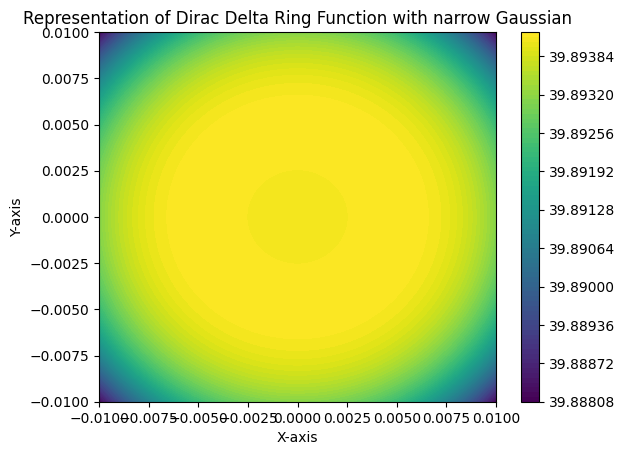

In [180]:
# Define Delta Dirac Function
MEAN = 0
SIGMA = 1e-2


def dirac_delta_approx(x, mean=MEAN, sigma=SIGMA):
    return 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(x-mean)**2 / (2 * sigma**2))


def dirac_delta_ring(x, y, x0=xmax*0.5, y0=ymax*0.5, r0=np.min([xmax, ymax])*0.25):
    return dirac_delta_approx((x-x0)**2 + (y-y0)**2 - r0**2)


# Plot dirac ring function
x = np.linspace(-0.01, 0.01, 100)
y = np.linspace(-0.01, 0.01, 100)
x, y = np.meshgrid(x, y)
delta = dirac_delta_ring(x, y, 0, 0, 0.005)

plt.contourf(x, y, delta, cmap='viridis', levels=100)
plt.title('Representation of Dirac Delta Ring Function with narrow Gaussian')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()
plt.show()

In [181]:
# Неоднородность в уравнении
def f(x, y):
    return -(ro * g + M * g / 2 / np.pi * dirac_delta_ring(x, y))

# Граничные условия


def phi_L(y):
    return 0


def phi_R(y):
    return 0


def phi_B(x):
    return 0


def phi_T(x):
    return 0

In [182]:
# Характерное разбиение
h0 = 0.002
lx = xmax - xmin
ly = ymax - ymin

nx = int(np.round(lx / h0)) + 1
ny = int(np.round(ly / h0)) + 1

beg_1 = time.time()

# Узлы сетки
x, hx = np.linspace(xmin, xmax, nx, retstep=True)
y, hy = np.linspace(ymin, ymax, ny, retstep=True)
X, Y = np.meshgrid(x, y, indexing='ij')

N = np.arange(0, X.size, dtype=int).reshape((nx, ny))
print(N)
print(N.shape)

[[     0      1      2 ...    498    499    500]
 [   501    502    503 ...    999   1000   1001]
 [  1002   1003   1004 ...   1500   1501   1502]
 ...
 [249498 249499 249500 ... 249996 249997 249998]
 [249999 250000 250001 ... 250497 250498 250499]
 [250500 250501 250502 ... 250998 250999 251000]]
(501, 501)


In [183]:
cx = -((nx - 1) / lx)**2  # -1/hx**2
cy = -((ny - 1) / ly)**2  # -1/hy**2
bb = -2.0 * (cx + cy) + k  # (2/hx**2 + 2/hy**2 - k)
print(cx, cy, bb)

-250000.0 -250000.0 1000050.0


In [184]:
beg_1 = time.time()
R1 = N[1:-1, 1:-1].flatten()
C1 = N[1:-1, 1:-1].flatten()
V1 = np.full_like(R1, bb)

R2 = N[1:-1, 1:-1].flatten()
C2 = N[0:-2, 1:-1].flatten()
V2 = np.full_like(R2, cx)

R3 = N[1:-1, 1:-1].flatten()
C3 = N[2:, 1:-1].flatten()
V3 = np.full_like(R3, cx)

R4 = N[1:-1, 1:-1].flatten()
C4 = N[1:-1, 0:-2].flatten()
V4 = np.full_like(R4, cy)

R5 = N[1:-1, 1:-1].flatten()
C5 = N[1:-1, 2:].flatten()
V5 = np.full_like(R5, cy)

# Граничные условия
R6 = N[0, :]
C6 = N[0, :]
V6 = np.ones_like(R6)

R7 = N[-1, :]
C7 = N[-1, :]
V7 = np.ones_like(R7)

R8 = N[1:-1, 0]
C8 = N[1:-1, 0]
V8 = np.ones_like(R8)

R9 = N[1:-1, -1]
C9 = N[1:-1, -1]
V9 = np.ones_like(R9)

row = np.concatenate((R1,
                      R2, R3, R4, R5,
                      R6, R7, R8, R9))
col = np.concatenate((C1,
                      C2, C3, C4, C5,
                      C6, C7, C8, C9))
val = np.concatenate((V1,
                      V2, V3, V4, V5,
                      V6, V7, V8, V9))

A = sp.csc_matrix((val, (row, col)))

F = f(X, Y)
F[0, :] = phi_L(Y[0, :])
F[-1, :] = phi_R(Y[-1, :])
F[:,  0] = phi_B(X[:, 0])
F[:, -1] = phi_T(X[:, -1])

end_1 = time.time()

beg_2 = time.time()
u = sp.linalg.spsolve(A, F.ravel())
u = u.reshape(X.shape)
end_2 = time.time()

print('fill matrices:  %.5f sec' % (end_1 - beg_1))
print('linalg.spsolve: %.5f sec' % (end_2 - beg_2))

fill matrices:  0.05998 sec
linalg.spsolve: 10.51347 sec


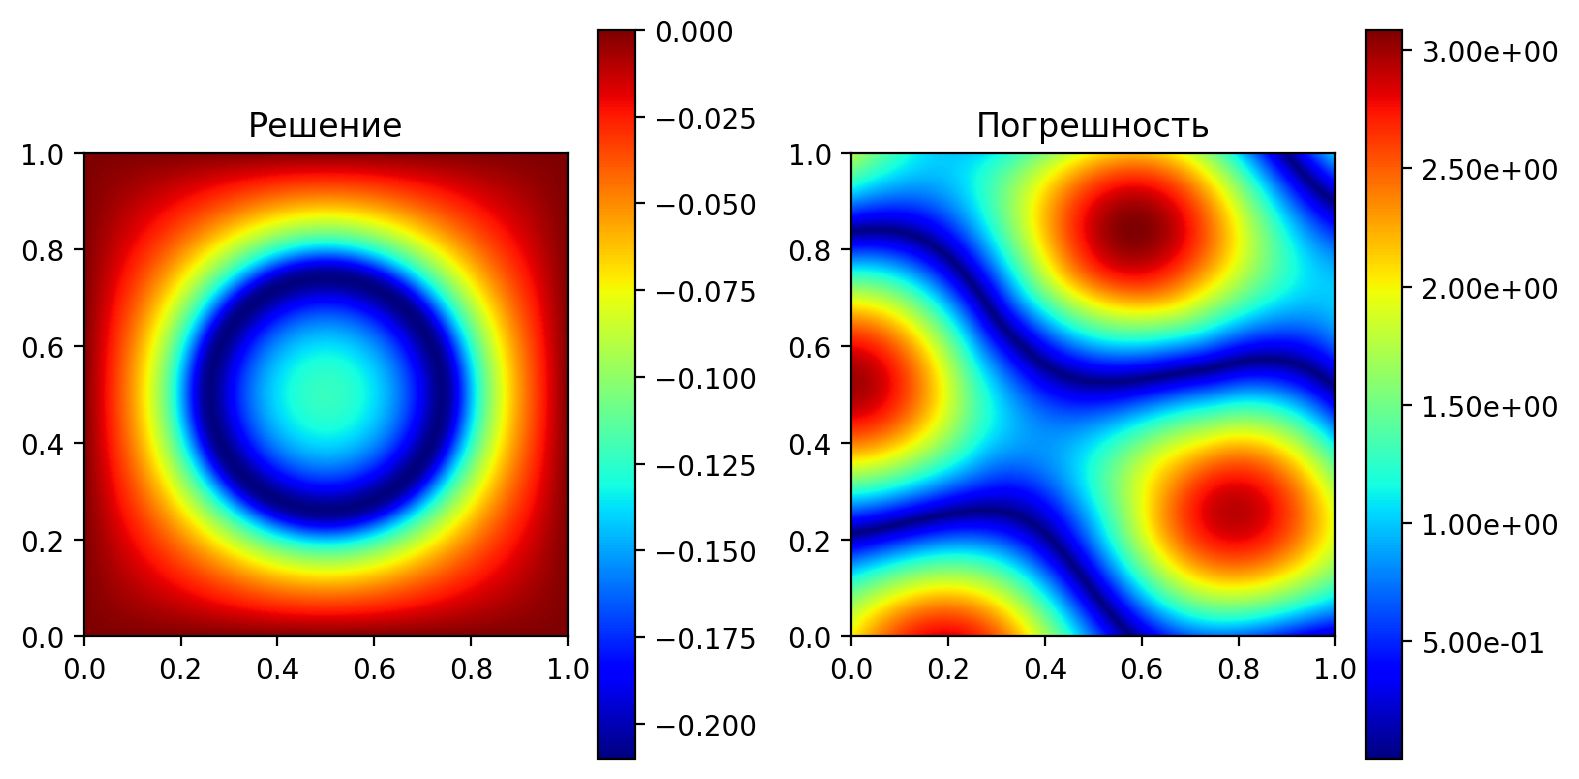

In [185]:
fig = plt.figure(dpi=200, figsize=(8.0, 4.0))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

options = {'cmap': 'jet',
           'aspect': 'equal',
           'origin': 'lower',
           'extent': [xmin - 0.5 * hx, xmax + 0.5 * hx,
                      ymin - 0.5 * hy, ymax + 0.5 * hy],
           'interpolation': 'nearest'}

ax1.set_title('Решение')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
img1 = ax1.imshow(u.T, **options)
fig.colorbar(img1, ax=ax1)

ax2.set_title('Погрешность')
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
img2 = ax2.imshow(np.abs(u - u_exact(X, Y)).T, **options)
fig.colorbar(img2, ax=ax2, format='%.2e')

fig.tight_layout()
plt.show()

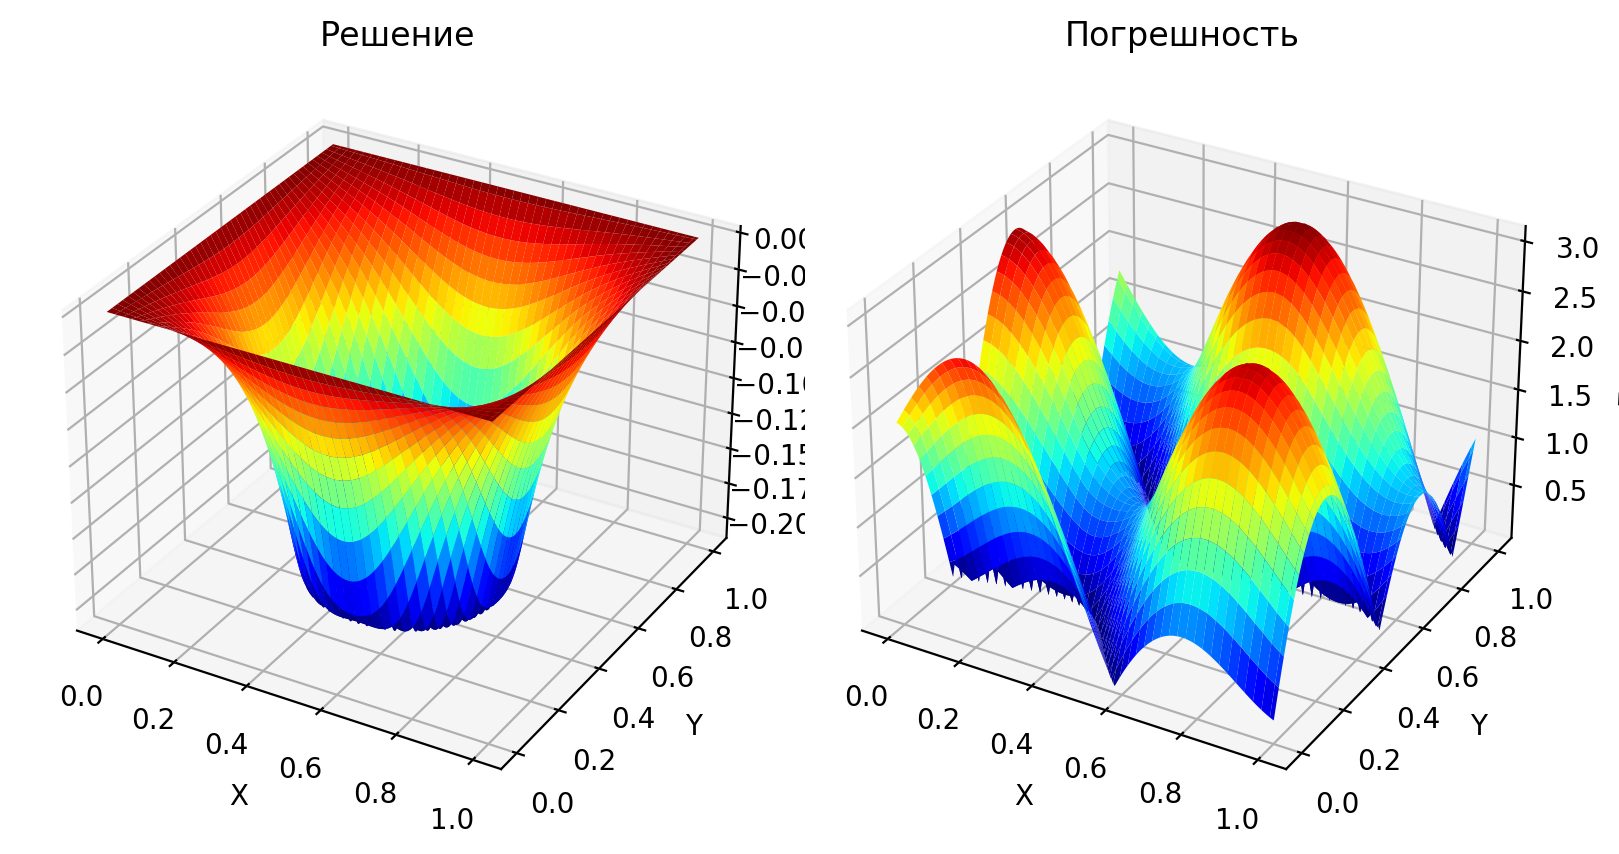

In [186]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(dpi=200, figsize=(8.0, 6.0))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.set_title('Решение')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('U')
ax1.plot_surface(X, Y, u, cmap='jet')

ax2.set_title('Погрешность')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Error')
ax2.plot_surface(X, Y, np.abs(u - u_exact(X, Y)), cmap='jet')

fig.tight_layout()
plt.show()